In [2]:
import pandas as pd
import json
import os

In [ ]:
i_metrics_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.json'
a_metrics_path = i_metrics_path.replace('instrument', 'action')
t_metrics_path = i_metrics_path.replace('instrument', 'tissue')

with open(i_metrics_path, 'r') as f:
    i_metrics = json.load(f)

with open(a_metrics_path, 'r') as f:
    a_metrics = json.load(f)
    
with open(t_metrics_path, 'r') as f:
    t_metrics = json.load(f)

### Procedure + Task Tables

In [48]:
annotations_df = pd.read_csv('/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/iat_predictor_splits/full.csv').assign(task=lambda x: x['task'].map(task_normalization_json))
proc_df = annotations_df[['procedure', 'procedure_defn']].drop_duplicates().reset_index(drop=True)
task_normalization_json = json.load(open('/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/iat/task_normalization.json'))
task_df = annotations_df[['task', 'task_defn']].drop_duplicates().dropna().drop_duplicates('task').reset_index(drop=True)

In [49]:
for i in range(len(proc_df)):
    print(f"{proc_df.iloc[i]['procedure']}")
    print(f"{proc_df.iloc[i]['procedure_defn']}")
    print("-" * 100)

radical prostatectomy
Radical prostatectomy is a surgical procedure that involves the complete removal of the prostate gland along with some surrounding tissue, including the seminal vesicles and sometimes nearby lymph nodes. This procedure is primarily performed to treat localized prostate cancer and aims to eliminate cancerous cells while preserving as much surrounding healthy tissue as possible. It can be done through open surgery or minimally invasive techniques, such as laparoscopic or robotic-assisted surgery. Postoperative recovery may involve managing urinary incontinence and erectile dysfunction, which are common side effects.
----------------------------------------------------------------------------------------------------
simple prostatectomy
A simple prostatectomy is a surgical procedure aimed at removing the prostate gland and some surrounding tissue to alleviate symptoms caused by benign prostatic hyperplasia (BPH) or prostate cancer. This procedure is typically perform

In [50]:
annotations_df['procedure'].value_counts()

procedure
radical prostatectomy     822
simple prostatectomy      279
nephrectomy               244
partial nephrectomy        67
inguinal hernia repair     27
nephroureterectomy         11
Name: count, dtype: int64

In [64]:
for i in range(len(task_df)):
    # task = task_df.iloc[i]['task']
    # count = annotations_df[annotations_df['task'] == task]['task'].count()
    # defn = task_df.iloc[i]['task_defn']
    # print(f"{task} & {count} & {defn} \\" + '\\')
    print(f"{task_df.iloc[i]['task']}")
    # print(f"{annotations_df[annotations_df['task'] == task_df.iloc[i]['task']]['task'].count()}")
    print(f"Task Definition: {task_df.iloc[i]['task_defn']}")
    print("-" * 100)
    
    

Bladder Neck
Task Definition: The bladder neck is the region where the bladder connects to the urethra, and during surgical teaching, it is crucial to demonstrate the anatomy and function of this area, emphasizing its role in urinary continence and the potential complications that can arise from surgical manipulation, such as in prostatectomy procedures. Instruct trainees on identifying the bladder neck's landmarks and techniques for preserving its integrity during surgery to minimize postoperative complications.
----------------------------------------------------------------------------------------------------
SV
Task Definition: In urology surgery, the teaching step "SV" refers to "Surgical Visualization," which emphasizes the importance of clear and effective visualization of the surgical field through proper positioning, retraction, and use of appropriate lighting and magnification techniques to enhance the surgeon's ability to identify anatomical structures and perform precise in

### Table 1

In [4]:
import pandas as pd
import os
import json
import numpy as np

iat_metrics_dir = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics'
models = ['surgvlp', 'peskavlp', 'hecvl']
input_types = ['vision', 'vision+procedure', 'vision+procedure+task']
iat_cols = ['instrument', 'action', 'tissue']

In [13]:
only_embs_rows = []
for iat_col in iat_cols:
    for model in models:
        for input_type in input_types:
            metrics_path = os.path.join(
                iat_metrics_dir,
                f'{iat_col}-{model}-{input_type}-none=100-final.json'
            )
            if os.path.exists(metrics_path):
                with open(metrics_path, 'r') as f:
                    metrics = json.load(f)
                only_embs_rows.append({
                    'IAT': iat_col,
                    'Model': model,
                    'Input Type': input_type,
                    'AUROC': metrics["auroc_mean"],
                    'AUROC-std': np.std(metrics["auroc_scores"]),
                    'Num Tracks': 0
                })
only_embs_df = pd.DataFrame(only_embs_rows)
only_embs_df = only_embs_df.pivot_table(
    index=['Input Type', 'Model', 'Num Tracks'],
    columns='IAT',
    values=['AUROC', 'AUROC-std']
).reset_index()
only_embs_df.columns.name = None
only_embs_df = only_embs_df.rename(columns={
    'action': 'Action',
    'instrument': 'Instrument',
    'tissue': 'Tissue'
})
# only_embs_df = only_embs_df[['Input Type', 'Model', 'Num Tracks', 'Instrument', 'Action', 'Tissue']]
only_embs_df = only_embs_df[[
    ('Input Type', ''),
    ('Model', ''),
    ('Num Tracks', ''),
    ('AUROC', 'Instrument'),
    ('AUROC-std', 'Instrument'),
    ('AUROC', 'Action'),
    ('AUROC-std', 'Action'),
    ('AUROC', 'Tissue'),
    ('AUROC-std', 'Tissue')
]].round(2)
# only_embs_df 

In [9]:
hybrid_rows = []
all_num_tracks = [1, 5, 15, 30, 100, 'no_filter']
for iat_col in iat_cols:
    for model in models:
        for input_type in input_types:
            for num_tracks in all_num_tracks:
                if num_tracks == 'no_filter':
                    metrics_path = os.path.join(
                        iat_metrics_dir,
                        f'{iat_col}-{model}-{input_type}+tracks-none=100-no_filter_instrument_tracks-final.json'
                    )
                else:
                    metrics_path = os.path.join(
                        iat_metrics_dir,
                        f'{iat_col}-{model}-{input_type}+tracks-none=100-num_tracks={num_tracks}-final.json'
                    )
                if os.path.exists(metrics_path):
                    with open(metrics_path, 'r') as f:
                        metrics = json.load(f)
                    hybrid_rows.append({
                        'IAT': iat_col,
                        'Model': model,
                        'Input Type': input_type + ' + tracks',
                        'AUROC': metrics['auroc_mean'],
                        'AUROC-std': np.std(metrics["auroc_scores"]),
                        'Num Tracks': num_tracks
                    })
hybrid_df = pd.DataFrame(hybrid_rows)
hybrid_df = hybrid_df.pivot_table(
    index=['Input Type', 'Model', 'Num Tracks'],
    columns='IAT',
    values=['AUROC', 'AUROC-std']
).reset_index()
hybrid_df.columns.name = None
hybrid_df = hybrid_df.rename(columns={
    'action': 'Action',
    'instrument': 'Instrument',
    'tissue': 'Tissue'
})
hybrid_df = hybrid_df[(hybrid_df['Input Type'] == 'vision+procedure+task + tracks')]
# hybrid_df = hybrid_df[['Input Type', 'Model', 'Num Tracks', 'Instrument', 'Action', 'Tissue']]
hybrid_df = hybrid_df[[
    ('Input Type', ''),
    ('Model', ''),
    ('Num Tracks', ''),
    ('AUROC', 'Instrument'),
    ('AUROC-std', 'Instrument'),
    ('AUROC', 'Action'),
    ('AUROC-std', 'Action'),
    ('AUROC', 'Tissue'),
    ('AUROC-std', 'Tissue')
]].round(2)
# hybrid_df

In [12]:
full_df = pd.concat([only_embs_df, hybrid_df]).reset_index(drop=True)
full_df

# vision, vison+procedure, vision+procedure+task, vision+procedure+task+tracks
df1 = full_df.copy()
df1 = df1[df1['Num Tracks'].isin([0, 15])].reset_index(drop=True)
df1 = df1[[
    ('Input Type', ''),
    ('Model', ''),
    # ('Num Tracks', ''),
    ('AUROC', 'Instrument'),
    ('AUROC-std', 'Instrument'),
    ('AUROC', 'Action'),
    ('AUROC-std', 'Action'),
    ('AUROC', 'Tissue'),    
    ('AUROC-std', 'Tissue')
]].round(2)
df1

Input Type     Model      AUROC  AUROC-std  AUROC  \
IAT                                           Instrument Instrument Action   
0                            vision     hecvl       0.68       0.04   0.60   
1                            vision  peskavlp       0.67       0.03   0.60   
2                            vision   surgvlp       0.65       0.02   0.58   
3                  vision+procedure     hecvl       0.68       0.03   0.60   
4                  vision+procedure  peskavlp       0.68       0.03   0.59   
5                  vision+procedure   surgvlp       0.67       0.02   0.58   
6             vision+procedure+task     hecvl       0.71       0.04   0.61   
7             vision+procedure+task  peskavlp       0.69       0.03   0.60   
8             vision+procedure+task   surgvlp       0.70       0.01   0.60   
9    vision+procedure+task + tracks     hecvl       0.74       0.03   0.62   
10   vision+procedure+task + tracks  peskavlp       0.74       0.03   0.63   
11   vision+procedure+task + tracks   surgvlp       0.73       0.03   0.61   

    AUROC-std  AUROC AUROC-std  
IAT    Action Tissue    Tissue  
0        0.01   0.74      0.02  
1        0.02   0.74      0.02  
2        0.02   0.70      0.01  
3        0.01   0.76      0.02  
4        0.02   0.75      0.02  
5        0.02   0.73      0.01  
6        0.01   0.77      0.03  
7        0.01   0.74      0.02  
8        0.01   0.76      0.02  
9        0.01   0.77      0.01  
10       0.02   0.79      0.01  
11       0.01   0.79      0.01

### Confidence Thresholding

In [81]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np
import ast

# --- 1. Load Data ---
pred_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_predictions/peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.csv'
# pred_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_predictions/peskavlp-vision+procedure+task-none=100-final-with_conf.csv'


pred_df = pd.read_csv(pred_path)

# --- 2. Encode Text Labels to Numbers ---
# Encode 'instrument'
i_encoder = LabelEncoder().fit(pd.concat([pred_df['instrument'], pred_df['instrument_pred']]).dropna().unique())
pred_df['instrument_encoded'] = pred_df['instrument'].apply(lambda x: i_encoder.transform([x])[0] if pd.notna(x) and x in i_encoder.classes_ else -1)
pred_df['instrument_pred_encoded'] = pred_df['instrument_pred'].apply(lambda x: i_encoder.transform([x])[0] if pd.notna(x) and x in i_encoder.classes_ else -1)

# Encode 'action'
a_encoder = LabelEncoder().fit(pd.concat([pred_df['action'], pred_df['action_pred']]).dropna().unique())
pred_df['action_encoded'] = pred_df['action'].apply(lambda x: a_encoder.transform([x])[0] if pd.notna(x) and x in a_encoder.classes_ else -1)
pred_df['action_pred_encoded'] = pred_df['action_pred'].apply(lambda x: a_encoder.transform([x])[0] if pd.notna(x) and x in a_encoder.classes_ else -1)

# Encode 'tissue'
t_encoder = LabelEncoder().fit(pd.concat([pred_df['tissue'], pred_df['tissue_pred']]).dropna().unique())
pred_df['tissue_encoded'] = pred_df['tissue'].apply(lambda x: t_encoder.transform([x])[0] if pd.notna(x) and x in t_encoder.classes_ else -1)
pred_df['tissue_pred_encoded'] = pred_df['tissue_pred'].apply(lambda x: t_encoder.transform([x])[0] if pd.notna(x) and x in t_encoder.classes_ else -1)


# --- 3. Calculate Metrics Across Confidence Levels ---
i_n = len(pred_df[pred_df['instrument'].notna()])
a_n = len(pred_df[pred_df['action'].notna()])
t_n = len(pred_df[pred_df['tissue'].notna()])

confidence_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
metrics = []

import warnings
warnings.filterwarnings('ignore')

for confidence_level in confidence_levels:
    # print(f"CONFIDENCE LEVEL: {confidence_level}")
    i_df = pred_df[(pred_df['instrument'].notna()) & (pred_df['instrument_conf'] > confidence_level)]
    a_df = pred_df[(pred_df['action'].notna()) & (pred_df['action_conf'] > confidence_level)]
    t_df = pred_df[(pred_df['tissue'].notna()) & (pred_df['tissue_conf'] > confidence_level)]
    
    row_dict = {'confidence_level': confidence_level}
    
    # We use a loop to avoid repeating code for each category
    for prefix, df, total_count, encoder in [('instrument', i_df, i_n, i_encoder), ('action', a_df, a_n, a_encoder), ('tissue', t_df, t_n, t_encoder)]:
        pct = len(df) / total_count if total_count > 0 else 0
        row_dict[f'{prefix}_pct'] = pct
        if not df.empty:
            true_labels = df[f'{prefix}_encoded']
            pred_labels = df[f'{prefix}_pred_encoded']
            
            # --- NEW: Calculate average confidence ---
            row_dict[f'{prefix}_avg_conf'] = df[f'{prefix}_conf'].mean()
            
            row_dict[f'{prefix}_f1'] = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
            row_dict[f'{prefix}_precision'] = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
            row_dict[f'{prefix}_recall'] = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
            
            # --- ROC AUC Calculation ---
            if f'{prefix}_pred_probs' in df.columns:
                true_labels_binarized = label_binarize(true_labels, classes=range(len(encoder.classes_)))
                
                ordered_classes = encoder.classes_
                def get_ordered_probs(prob_dict_str):
                    prob_dict = ast.literal_eval(prob_dict_str)
                    return [prob_dict.get(cls, 0) for cls in ordered_classes]

                pred_probas = np.array(df[f'{prefix}_pred_probs'].apply(get_ordered_probs).to_list())
                
                
                if (true_labels_binarized.shape[1] == pred_probas.shape[1]) and pct > 0.01:
                    row_dict[f'{prefix}_roc_auc'] = roc_auc_score(
                        true_labels_binarized, 
                        pred_probas, 
                        multi_class='ovo', 
                        average='weighted'
                    )
                else:
                    row_dict[f'{prefix}_roc_auc'] = np.nan

        else:
            # --- NEW: Handle empty case for avg_conf ---
            row_dict[f'{prefix}_avg_conf'] = np.nan
            row_dict[f'{prefix}_f1'] = np.nan
            row_dict[f'{prefix}_precision'] = np.nan
            row_dict[f'{prefix}_recall'] = np.nan
            row_dict[f'{prefix}_roc_auc'] = np.nan
            
    metrics.append(row_dict)

# --- 4. Display and Save Results ---
metrics_df = pd.DataFrame(metrics)

metrics_df = metrics_df.round(2).sort_values(by='confidence_level', ascending=False)
metrics_df = metrics_df[['confidence_level', 'instrument_pct', 'instrument_roc_auc', 'action_pct', 'action_roc_auc', 'tissue_pct', 'tissue_roc_auc']]
metrics_df

confidence_level  instrument_pct  instrument_roc_auc  action_pct  \
9               0.9            0.00                 NaN        0.00   
8               0.8            0.01                 NaN        0.00   
7               0.7            0.03                0.82        0.00   
6               0.6            0.06                0.73        0.00   
5               0.5            0.14                0.76        0.00   
4               0.4            0.29                0.75        0.02   
3               0.3            0.66                0.74        0.08   
2               0.2            0.98                0.74        0.34   
1               0.1            1.00                0.74        0.85   
0               0.0            1.00                0.74        1.00   

   action_roc_auc  tissue_pct  tissue_roc_auc  
9             NaN        0.00             NaN  
8             NaN        0.00             NaN  
7             NaN        0.02            0.81  
6             NaN        0.07            0.77  
5             NaN        0.18            0.82  
4            0.63        0.38            0.82  
3            0.66        0.72            0.82  
2            0.67        0.96            0.81  
1            0.64        1.00            0.81  
0            0.64        1.00            0.81

### Confusion Matrix Plotting

In [65]:
import pandas as pd
import json
import os

In [ ]:
# i_metrics_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task-none=100-final.json'
i_metrics_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.json'
a_metrics_path = i_metrics_path.replace('instrument', 'action')
t_metrics_path = i_metrics_path.replace('instrument', 'tissue')

with open(i_metrics_path, 'r') as f:
    i_metrics = json.load(f)

with open(a_metrics_path, 'r') as f:
    a_metrics = json.load(f)
    
with open(t_metrics_path, 'r') as f:
    t_metrics = json.load(f)

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix_row_normalized(ax, cm, labels, title):
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)

    ax.imshow(cm_normalized, origin='upper', cmap='Blues')
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(title, fontsize=9) 
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    for (x, y), v in np.ndenumerate(cm):
        ax.text(y, x, f'{int(v)}', ha='center', va='center', fontsize=7,
                color='white' if cm_normalized[x, y] > 0.5 else 'black')

def plot_confusion_matrices(ax, cm, labels, title):
    ax.imshow(cm, origin='upper')   
    ax.set_xticks(range(len(labels)), labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)), labels)
    ax.set_title(title, fontsize=9) 
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

    for (x, y), v in np.ndenumerate(cm):
        ax.text(y, x, int(v), ha='center', va='center', fontsize=7)


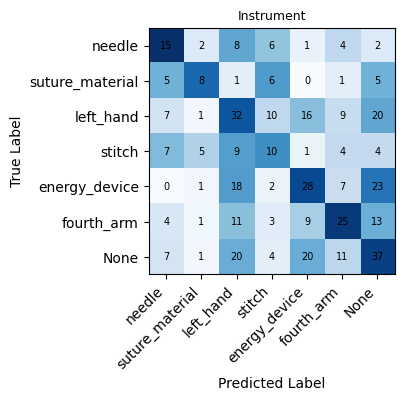

In [78]:
n_rows, n_cols = 1, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2 * n_cols, 3.2 * n_rows))

i_cm = np.array(i_metrics['confusion_matrix'])
plot_confusion_matrix_row_normalized(axes, i_cm, i_metrics['confusion_matrix_labels'], 'Instrument')

plt.show()

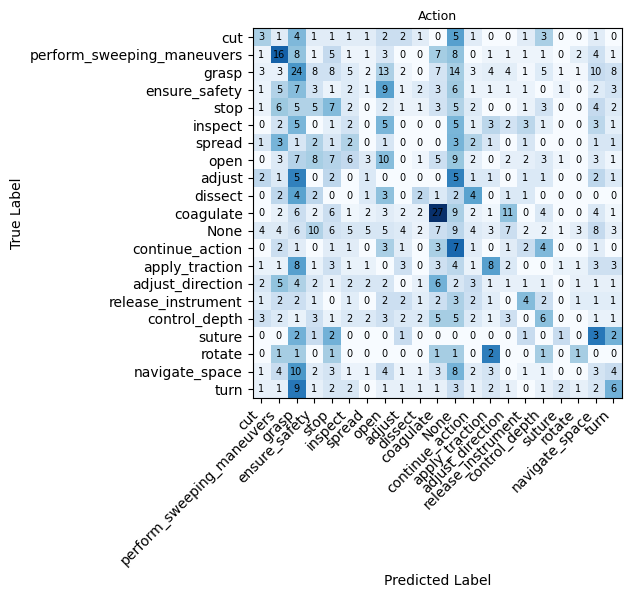

In [79]:
n_rows, n_cols = 1, 1
fig, axes = plt.subplots(n_rows, n_cols)

a_cm = np.array(a_metrics['confusion_matrix'])
plot_confusion_matrix_row_normalized(axes, a_cm, a_metrics['confusion_matrix_labels'], 'Action')

plt.show()

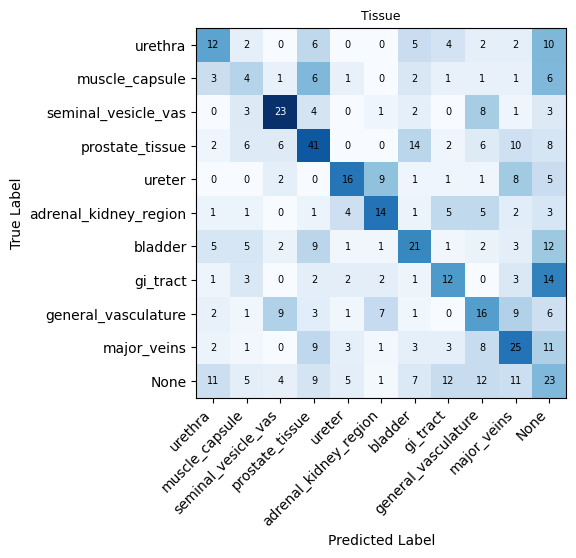

In [80]:
fig, axes = plt.subplots(n_rows, n_cols)

t_cm = np.array(t_metrics['confusion_matrix'])
plot_confusion_matrix_row_normalized(axes, t_cm, t_metrics['confusion_matrix_labels'], 'Tissue')

plt.show()